# A Study of Scooter Rental Service Users and their Trips

We have information on several GoFast mobile app users from several cities, as well as their trips. \
In the study, we will study the main parameters, calculate the monthly revenue from each user, and test a number of hypotheses that can help the business grow:

* Do users with a subscription spend more time on trips?
* Can we say that the average distance that users with a subscription travel per trip does not exceed the optimal distance from the point of view of scooter wear?
* Will the monthly revenue from users with a subscription be higher than the revenue from users without a subscription?


To travel around the city, GoFast users use a mobile app. The service can be used:

* without a subscription:
    * there is no subscription fee;
    * the cost of one minute of travel is 8 rubles;
    * the cost of starting the trip is 50 rubles;
* with an Ultra subscription
    * the subscription fee is 199 rubles per month;
    * the cost of one minute of travel is 6 rubles;
    * the cost of starting is free.


**Data Description**

The data is contained in three files:

File `users_go.csv`:

* `user_id` — уникальный идентификатор пользователя
* `name` — имя пользователя
* `age` — возраст
* `city` — город
* `subscription_type` —	тип подписки (free, ultra)

* `user_id` — unique user id
* `name` — user name
* `age` — age
* `city` — city
* `subscription_type` — subscription type (free, ultra)

File `rides_go.csv`:

* `user_id` — unique user id
* `distance` — distance the user has traveled in the current session (in meters)
* `duration` — session duration (in minutes) — time from the moment the user clicked the "Start trip" button until the moment he clicked the "End trip" button
* `date` — date of the trip

File `subscriptions_go.csv`:

* `subscription_type` — subscription type
* `minute_price` — cost of one minute of ride for this subscription
* `start_ride_price` — cost of starting a ride
* `subscription_fee` — cost of monthly payment

## Loading and examination of data

In [1]:
#importing Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from math import factorial
from scipy.stats import binom
from math import sqrt
import warnings
import jupyter_black

In [2]:
#save files into separate variables
users = pd.read_csv('users_go.csv')
rides = pd.read_csv('rides_go.csv')
subscriptions = pd.read_csv('subscriptions_go.csv')

In [3]:
pd.set_option(
    "display.max_columns", None
)  # expand the output area so that all columns are visible
warnings.filterwarnings("ignore")  # disable warnings about changes in libraries
pd.options.display.float_format = (
    "{:.3f}".format
)  # set the setting to display numbers in float format
jupyter_black.load()  # beautify Python code

Let's display the first lines from each dataset and apply the info() method:

In [4]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [6]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919,25.600,2021-01-01
1,1,2617.592,15.817,2021-01-18
2,1,754.160,6.232,2021-04-20
3,1,2694.783,18.511,2021-08-11
4,1,4028.687,26.266,2021-08-28


In [7]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [8]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [9]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


### Interim conclusion

* There are no missing values in any of the data sets.
* It is worth checking `rides` and `users` for duplicates.
* We need to change the `date` column type (`rides` dataframe) to datetime64.

## Data preprocessing

### Changing data types

In [10]:
# changing the object type to datetime64.
rides["date"] = pd.to_datetime(rides["date"], format="%Y-%m-%d")

### Adding new column

Let's add a column `month` to the `rides` dataframe, where we'll add data about the month of the trip.

In [11]:
rides["month"] = rides["date"].dt.month

Let's clarify the time period covered by the data:

In [12]:
print("Earliest date in the dataset:", rides["date"].min())
print("Latest date in the dataset:", rides["date"].max())

Earliest date in the dataset: 2021-01-01 00:00:00
Latest date in the dataset: 2021-12-30 00:00:00


The data covers the period 2021.

### Finding and removing duplicate records

#### Finding exact duplicate rows

First, let's check the `rides` and `users` dataframes for exact rows.

In [13]:
rides.duplicated().sum()

0

In [14]:
users.duplicated().sum()

31

There are no obvious duplicates in `rides`, but 31 completely matching lines were found in `users`.

This dataframe contains data on unique clients with a unique user id. So duplicates should be removed.

In [15]:
# remove duplicate lines
users = users.drop_duplicates()

#### Finding partial duplicates


In this case, we are only interested in the `users` dataframe, which has columns with string values. They may contain errors and typos.

There are three such columns:
* `name` - user name
* `city` - city
* `subscription_type` - subscription type (free, ultra)

Also check the 'user_id' column for duplicated IDs.

In [16]:
# sort the 'user_id' column by unique values, output largest frequency
users["user_id"].value_counts().max()

1

All values in the `user_id` column occur only once.

--- 

Next, examine the `'name'` column:

In [17]:
# display unique values in alphabetical order
names_unique = np.sort(users["name"].unique())
for name in names_unique:
    print(name)

Агата
Аделина
Адель
Айдар
Александр
Александра
Алексей
Алина
Алиса
Алия
Алла
Альберт
Альбина
Алёна
Амалия
Амина
Амир
Анастасия
Анатолий
Ангелина
Андрей
Анжелика
Анна
Антон
Антонина
Ариана
Арина
Арсен
Арсений
Артемий
Артур
Артём
Богдан
Борис
Вадим
Валентина
Валерий
Валерия
Варвара
Василий
Василина
Василиса
Вера
Вероника
Виктор
Виктория
Виолетта
Виталий
Виталина
Влад
Влада
Владимир
Владислав
Владислава
Всеволод
Вячеслав
Галина
Георгий
Герман
Глеб
Гордей
Григорий
Давид
Дамир
Даниил
Данил
Данила
Даниэль
Дарина
Дарья
Демид
Денис
Диана
Дмитрий
Ева
Евгений
Евгения
Егор
Екатерина
Елена
Елизавета
Елисей
Есения
Жанна
Зарина
Захар
Злата
Иван
Игнат
Игорь
Ильдар
Илья
Инна
Ирина
Камилла
Карина
Каролина
Кира
Кирилл
Константин
Кристина
Ксения
Лариса
Лев
Леонид
Лиана
Лидия
Лилия
Любовь
Людмила
Мадина
Майя
Макар
Максим
Марат
Маргарита
Марина
Мария
Марк
Марсель
Матвей
Мелания
Милана
Милена
Мирон
Мирослав
Мирослава
Михаил
Назар
Наталия
Наталья
Наташа
Нелли
Ника
Никита
Николай
Нина
Одиссей
Оксана
Олег
Олес

There are no typos, all names are written uniformly. There are pairs of similar names, for example `Sofia and Sofya`,
`Natalia and Natalia`, but this can be attributed to different writing styles, and in the context of our study, such similarities in names are not critical. So we will leave them as is.

We will study the `city` column similarly:

In [18]:
# display unique values in alphabetical order
cities_unique = np.sort(users["city"].unique())
for name in cities_unique:
    print(name)

Екатеринбург
Краснодар
Москва
Омск
Пятигорск
Ростов-на-Дону
Сочи
Тюмень


Everything is fine here, the data in the table covers only 8 cities, there are no errors.

Let's move on to checking the `subscription_type` column. It can contain only two unique values `ultra` and `free`.

In [19]:
# show unique vallues in column
users["subscription_type"].unique()

array(['ultra', 'free'], dtype=object)

Everything is correct, there are no errors in the column.

### Interim conclusion

We have prepared the data for work:

* Checked the data for missing values
* In the `rides` dataset — added a new column `month`, and also corrected the type of the `date` column to datetime64

## Exploratory data analysis

### Distribution of users by cities

In [20]:
# sort unique values by number of mentions
users["city"].value_counts()

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

Visualizing data on a graph.

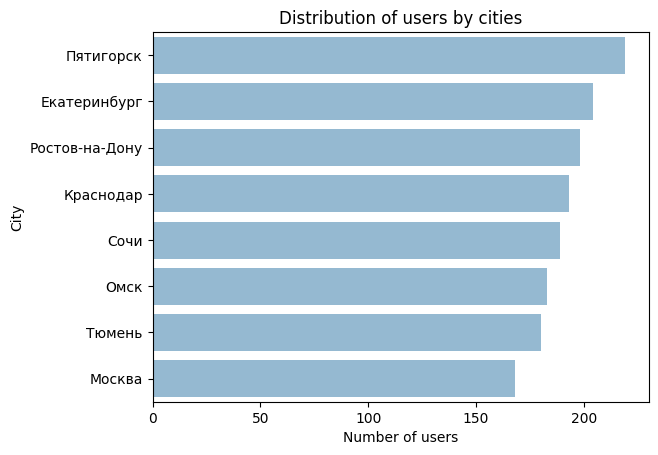

In [21]:
sns.set_palette("Blues_d")  # setting colors for the seaborn library

# preparing data for the graph
cities_frequency = users["city"].value_counts().reset_index()
cities_frequency.columns = ["City", "Number of users"]

# creating a barplot
sns.barplot(data=cities_frequency, x="Number of users", y="City").set(
    title="Distribution of users by cities"
);

**Observation:** It is interesting that the data has the most users from the small city of Pyatigorsk, and the least from the most populous city in Europe, Moscow.

### Ratio of users with and without subscription

In [22]:
# display the percentage for each option.
users["subscription_type"].value_counts(normalize=True) * 100

subscription_type
free    54.433
ultra   45.567
Name: proportion, dtype: float64

Visualize on a pie chart

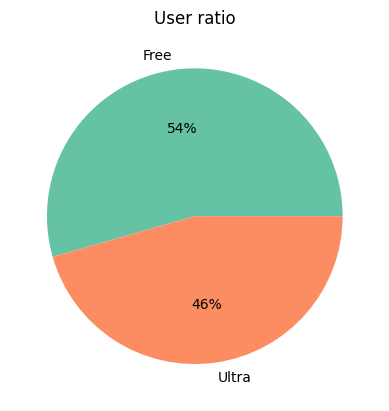

In [23]:
sns.set_palette("Set2")  # setting colors for the seaborn library

# creating a pie chart
plt.title("User ratio")
plt.pie(
    users["subscription_type"].value_counts(),
    labels=["Free", "Ultra"],
    autopct="%.0f%%",
);

**Observation:** There are 8% fewer users with a subscription than those who do without it.

### Age of users

Let's apply the describe() method to the `age` column and build a histogram.

In [24]:
users["age"].describe()

count   1534.000
mean      24.904
std        4.572
min       12.000
25%       22.000
50%       25.000
75%       28.000
max       43.000
Name: age, dtype: float64

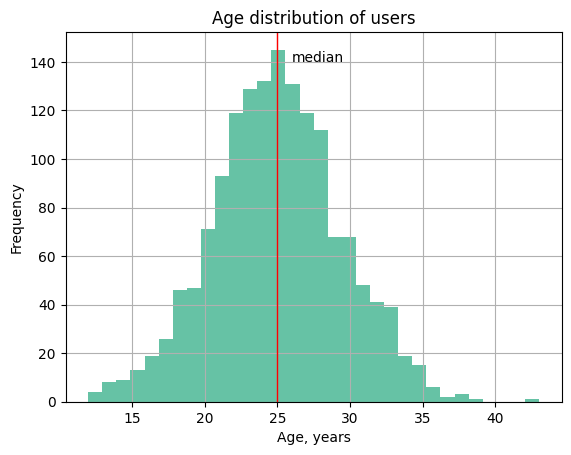

In [25]:
# create histogram
users["age"].hist(bins=32, range=(12, 43))

# assign axes and titles
plt.title("Age distribution of users")
plt.xlabel("Age, years")
plt.ylabel("Frequency")

# add median line
plt.axvline(users["age"].median(), color="r", linestyle="-", linewidth=1)
plt.text(26, 140, "median", rotation=0);

In [26]:
# display top-5 most frequent ages in the dataset
users["age"].value_counts().head()

age
25    145
24    132
26    131
23    129
22    119
Name: count, dtype: int64

**Observation:** the distribution is similar to normal, without outliers. The minimum age of the application users is 12 years. Most likely, the application limits the ability to register to children under 12. The most common users are 25 years old, the same age is obtained when calculating the mean and median for the column.

### Distance per trip

Let's apply the describe() method to the `distance` column and build a histogram.

In [27]:
rides["distance"].describe()

count   18068.000
mean     3070.660
std      1116.831
min         0.856
25%      2543.226
50%      3133.610
75%      3776.223
max      7211.008
Name: distance, dtype: float64

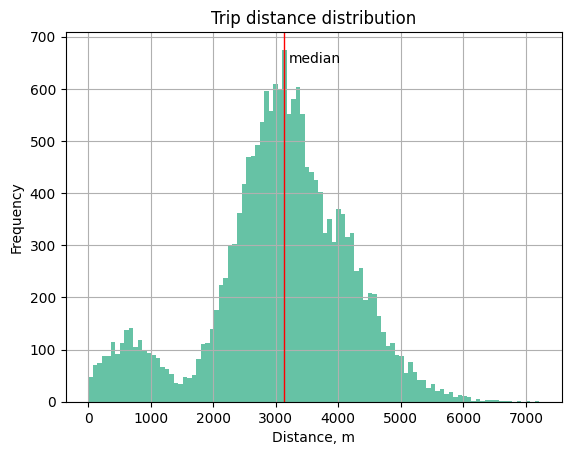

In [28]:
# create histogram
rides["distance"].hist(bins=100)

# assign axes and titles
plt.title("Trip distance distribution")
plt.xlabel("Distance, m")
plt.ylabel("Frequency")

# add median line
plt.axvline(rides["distance"].median(), color="r", linestyle="-", linewidth=1)
plt.text(3200, 650, "median", rotation=0);

**Observation:** The distribution has two distinct peaks, around 600 and 3100 meters. The median is located in the area of ​​the peak 3100 and is equal to 3133 m.

### Duration of trips

Let's apply the describe() method to the `duration` column and build a histogram.

In [29]:
rides["duration"].describe()

count   18068.000
mean       17.805
std         6.091
min         0.500
25%        13.598
50%        17.678
75%        21.725
max        40.824
Name: duration, dtype: float64

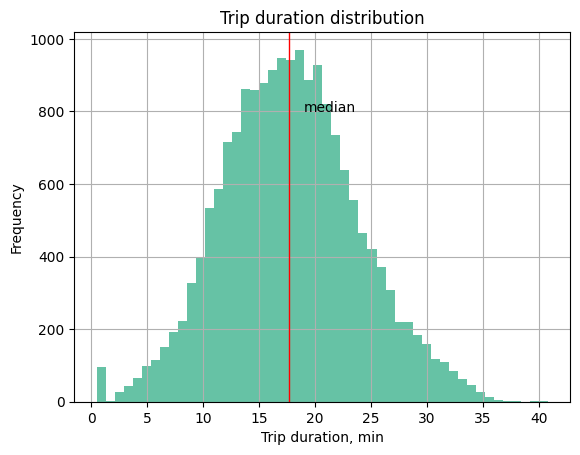

In [30]:
# create histogram
rides["duration"].hist(bins=50)

# assign axes and titles
plt.title("Trip duration distribution")
plt.xlabel("Trip duration, min")
plt.ylabel("Frequency")

# add median line
plt.axvline(rides["duration"].median(), color="r", linestyle="-", linewidth=1)
plt.text(19, 800, "median", rotation=0);

An interesting spike around 0.5 minutes. Let's slice the data for this duration and take a closer look.

In [31]:
rides.query("duration == 0.5")

,user_id,distance,duration,date,month
6531,701,4196.445,0.500,2021-08-31,8
6570,704,4830.824,0.500,2021-10-14,10
6680,712,4684.004,0.500,2021-03-04,3
6695,713,5215.643,0.500,2021-02-25,2
6768,718,5197.437,0.500,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.336,0.500,2021-01-19,1
17242,1477,6724.933,0.500,2021-01-12,1
17314,1483,4445.481,0.500,2021-03-06,3
17505,1496,5722.552,0.500,2021-02-14,2


95 rows with a duration of 30 seconds. At the same time, the distance in many lines is more than a kilometer. It looks like a failure in the duration calculation system.

Let's clarify what duration will be the shortest if we cut off 0.5

In [32]:
rides[rides["duration"] != 0.5].sort_values(by="duration", ascending=True).head()

,user_id,distance,duration,date,month
8906,880,11.284,2.036,2021-03-28,3
6691,712,23.963,2.053,2021-11-22,11
13308,1198,84.410,2.181,2021-06-11,6
17309,1482,111.299,2.223,2021-07-24,7
14081,1251,41.213,2.225,2021-04-15,4


Duration starts from 2 minutes.
Let's leave outlier lines in the table for now, since their number is very small relative to the size of the table.

**Observation:** The frequency distribution of durations resembles normal, there is a small suspicious peak around 0.5 minutes, the origin of which would be good to clarify. The median and mean are very close in value, fall on the top of the histogram, and are equal to approximately 18 minutes.

###  The characteristics of users with and without the Ultra subscription

Let's prepare the data to study these two categories. We'll combine the `users, trips, and subscriptions` values into one dataframe.
Then, based on the new dataframe, we'll create two more:
* data about users without a subscription;
* data about users with a subscription.

In [33]:
# dataframes merge
merged_data = pd.merge(rides, users, how="left", on="user_id")
merged_data = pd.merge(merged_data, subscriptions, how="left", on="subscription_type")

# display five first rows
merged_data.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919,25.600,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592,15.817,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.160,6.232,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783,18.511,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687,26.266,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Let's compare the number of rows in the original and new tables, and also check the new table for gaps and duplicates.

In [34]:
print("Number of rows in the original dataframe 'rides' = ", rides.shape[0])
print("Number of rows in the new dataframe 'merged_data' = ", merged_data.shape[0])
print(
    "Number of duplicates in the new dataframe 'merged_data' = ",
    merged_data.duplicated().sum(),
)
print()
print("Number of gaps in columns of the new dataframe 'merged_data':")
merged_data.isna().sum()

Number of rows in the original dataframe 'rides' =  18068
Number of rows in the new dataframe 'merged_data' =  18068
Number of duplicates in the new dataframe 'merged_data' =  0

Number of gaps in columns of the new dataframe 'merged_data':


user_id              0
distance             0
duration             0
date                 0
month                0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Everything is fine, we can move on to creating additional dataframes.

**Creating additional dataframes for two user categories.**

* `subscription_free` — data about users without a subscription;
* `subscription_ultra` — data about users with a subscription.

In [35]:
subscription_free = merged_data.query('subscription_type == "free"')
subscription_ultra = merged_data.query('subscription_type == "ultra"')

**Visualizing information about travel distance and time for users of both categories**

To compare information, first we will clarify the average and the sum of the columns for each category using a pivot table.

In [36]:
merged_data.pivot_table(
    index="subscription_type", values=["duration", "distance"], aggfunc=["sum", "mean"]
)

sum                mean         
                      distance   duration distance duration
subscription_type                                          
free              35230289.418 201178.039 3045.495   17.391
ultra             20250395.022 120522.904 3115.445   18.542

**Observation:** On average, Ultra users take longer and more distant trips. But the difference is small, only 70 m and 1 minute.

---

Now let's compare the distribution of durations on the histogram, and also build a bar plot, where we compare the sum of the durations of all trips for the period covered by the dataframe.

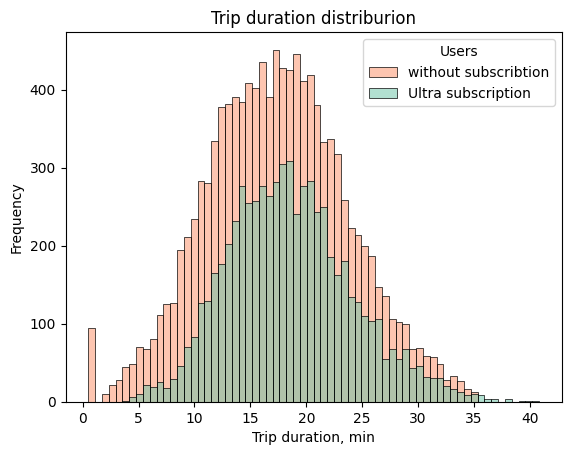

In [37]:
# setting colors for the seaborn library
sns.set_palette("Set2")

# assign axes and titles
plt.xlabel("Trip duration, min")
plt.ylabel("Frequency")

# create histogram
sns.histplot(data=merged_data, x="duration", hue="subscription_type").set(
    title="Trip duration distriburion"
)
plt.legend(
    title="Users",
    loc="upper right",
    labels=["without subscribtion", "Ultra subscription"],
);

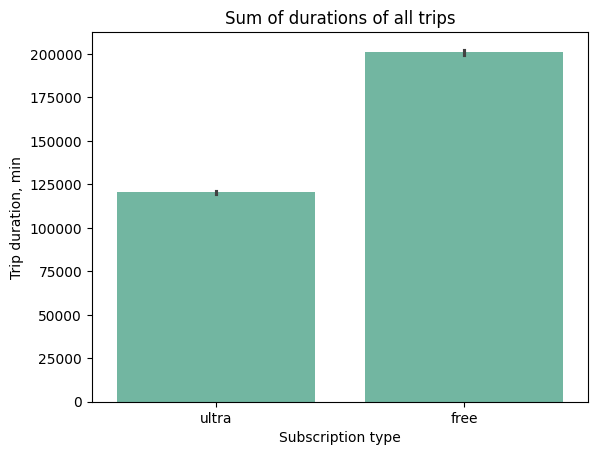

In [38]:
# creatin bar plot
sns.barplot(data=merged_data, y="duration", x="subscription_type", estimator=sum).set(
    title="Sum of durations of all trips"
)

# подписываем оси
plt.xlabel("Subscription type")
plt.ylabel("Trip duration, min");

**Observation:** The distributions are quite similar in terms of the peak location (we know that subscription users have a slightly longer average duration). It is clear that subscription users have fewer trips.

This is clearly visible in the bar plot above, which shows the sums of all durations. Subscription users used the service for 120,523 minutes (2,008 hours), while non-subscribers used the service for 201,178 minutes (3,353 hours).

The abnormal value of 0.5 minutes is only found among non-subscribers. Let's note this for future reference.

---

Now let's plot the same graphs for trip distance information.

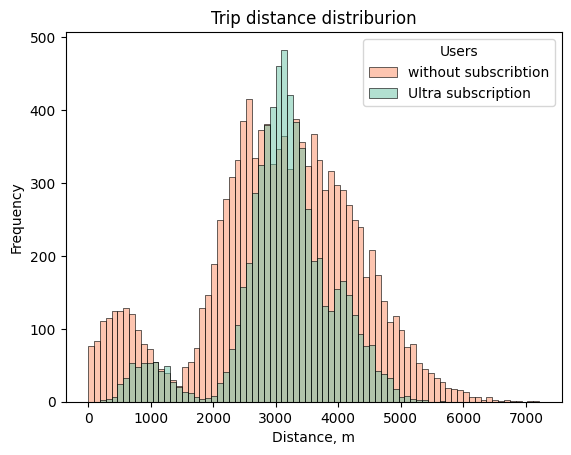

In [39]:
# assign axes and titles
plt.xlabel("Distance, m")
plt.ylabel("Frequency")

# create histogram
sns.histplot(data=merged_data, x="distance", hue="subscription_type").set(
    title="Trip distance distriburion"
)
plt.legend(
    title="Users",
    loc="upper right",
    labels=["without subscribtion", "Ultra subscription"],
);

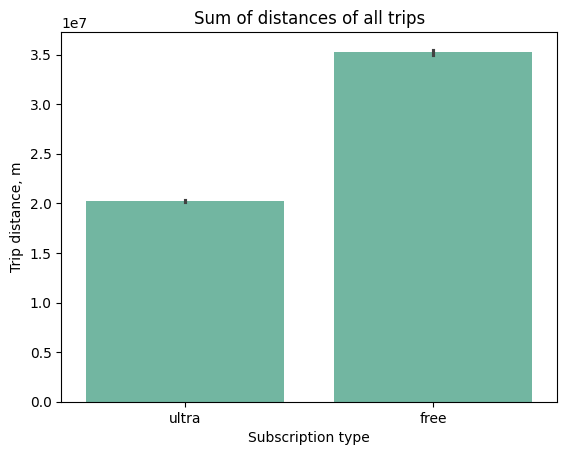

In [40]:
# create bar plot
sns.barplot(data=merged_data, y="distance", x="subscription_type", estimator=sum).set(
    title="Sum of distances of all trips"
)

# assign axes and titles
plt.xlabel("Subscription type")
plt.ylabel("Trip distance, m");

**Observation:** The distribution of distances among ultra subscribers is shifted to the right, especially the small peak on the left.
The overall distance among users with a subscription is lower.

### Interim conclusion

We have studied and described several parameters:
* **Frequency of cities** — the most users are from Pyatigorsk, the least — from Moscow
* **Ratio of users with and without a subscription** — users without a subscription — 54%, with a subscription — 45.6%
* **Age of users** — from 12 to 43 years old, on average, the age of users is 25 years old.
* **Distance covered by a user in one trip** — The distribution has two distinct peaks — about 600 and 3100 meters.
* **Duration of trips** — the average trip duration is 18 minutes.
* **Characteristics of users with and without an Ultra subscription** — on average, users with an Ultra subscription make longer and longer trips. But the difference is small, only 70 m and 1 minute. The total number of trips for users with a subscription is less.

## Revenue per user 

#### Creating pivot table

We are interested in: the total distance, number of trips and total time for each user for each month.

In [41]:
# rounded up each value from the duration column:
merged_data["duration"] = np.ceil(merged_data["duration"])

In [42]:
# create a pivot table with sorting by column 'user_id'
merged_data_pivot = merged_data.pivot_table(
    index="user_id",
    values=["duration", "distance"],
    columns=["month"],
    aggfunc=["sum", "count"],
)

# add a new level (months) to the index
merged_data_pivot = merged_data_pivot.stack()
# remove extra column
merged_data_pivot = merged_data_pivot.drop(
    columns=[("count", "duration")]
).reset_index()
# assign column names
merged_data_pivot.columns = [
    "user_id",
    "month",
    "total_distance",
    "total_time",
    "rides_count",
]
# change the data type in the 'rides_count' column
merged_data_pivot["rides_count"] = merged_data_pivot["rides_count"].astype("int")

In [43]:
# display the first rows of the resulting table
merged_data_pivot.head()

,user_id,month,total_distance,total_time,rides_count
0,1,1,7027.511,42.000,2
1,1,4,754.160,7.000,1
2,1,8,6723.471,46.000,2
3,1,10,5809.911,32.000,2
4,1,11,7003.499,56.000,3


Looks good, let's move on.

### Calculation of revenue by month

In the same dataframe, we will add a column with the monthly revenue that each user brought in. First, we will create a table that will contain subscription information for each unique user.

In [44]:
# make a slice of the original 'users' dataframe
users_slice = users[["user_id", "subscription_type"]]
# add information from the 'subscriptions' dataframe
user_subscription = pd.merge(
    users_slice, subscriptions, how="left", on="subscription_type"
)

user_subscription.head()

,user_id,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,ultra,6,0,199
1,2,ultra,6,0,199
2,3,ultra,6,0,199
3,4,ultra,6,0,199
4,5,ultra,6,0,199


Now let's add this information to the pivot table we created earlier:

In [45]:
merged_data_pivot = pd.merge(
    merged_data_pivot, user_subscription, how="left", on="user_id"
)
merged_data_pivot.head()

,user_id,month,total_distance,total_time,rides_count,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.511,42.000,2,ultra,6,0,199
1,1,4,754.160,7.000,1,ultra,6,0,199
2,1,8,6723.471,46.000,2,ultra,6,0,199
3,1,10,5809.911,32.000,2,ultra,6,0,199
4,1,11,7003.499,56.000,3,ultra,6,0,199


Now you can calculate the monthly revenue for each user.

In [46]:
# we calculate the revenue and add it to a new column 'monthly revenue'
merged_data_pivot["monthly_revenue"] = (
    (merged_data_pivot["start_ride_price"] * merged_data_pivot["rides_count"])
    + (merged_data_pivot["minute_price"] * merged_data_pivot["total_time"])
    + merged_data_pivot["subscription_fee"]
)
# remove extra column
merged_data_pivot = merged_data_pivot[
    [
        "user_id",
        "month",
        "total_distance",
        "total_time",
        "rides_count",
        "monthly_revenue",
        "subscription_type",
    ]
]

merged_data_pivot.head()

,user_id,month,total_distance,total_time,rides_count,monthly_revenue,subscription_type
0,1,1,7027.511,42.000,2,451.000,ultra
1,1,4,754.160,7.000,1,241.000,ultra
2,1,8,6723.471,46.000,2,475.000,ultra
3,1,10,5809.911,32.000,2,391.000,ultra
4,1,11,7003.499,56.000,3,535.000,ultra


Let's look at the revenue distribution on the graph and apply the describe() method to the new column.

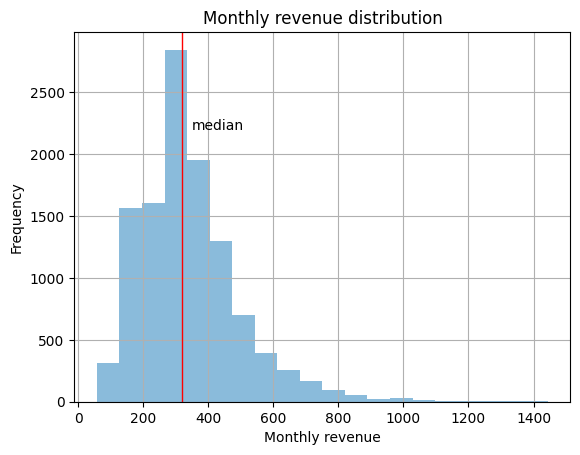

In [47]:
# setting colors
sns.set_palette("Blues_d")

# assign axes and titles
plt.title("Monthly revenue distribution")
plt.xlabel("Monthly revenue")
plt.ylabel("Frequency")

# create histogram
merged_data_pivot["monthly_revenue"].hist(bins=20)

# add median line
plt.axvline(
    merged_data_pivot["monthly_revenue"].median(), color="r", linestyle="-", linewidth=1
)
plt.text(350, 2200, "median", rotation=0);

In [48]:
merged_data_pivot["monthly_revenue"].describe()

count   11331.000
mean      342.304
std       153.875
min        58.000
25%       234.000
50%       319.000
75%       415.000
max      1444.000
Name: monthly_revenue, dtype: float64

Let's look at the relationship between revenue and total distance.

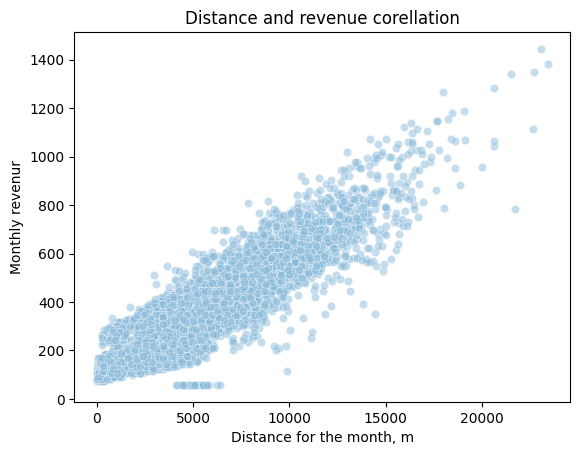

In [49]:
# create a scatterplot
sns.scatterplot(
    data=merged_data_pivot, x="total_distance", y="monthly_revenue", alpha=0.5
)

# assign axes and titles
plt.title("Distance and revenue corellation")
plt.xlabel("Distance for the month, m")
plt.ylabel("Monthly revenur");

In [50]:
print(
    "The Pearson correlation coefficient of the total distance to revenue is equal",
    round(
        merged_data_pivot["total_distance"].corr(merged_data_pivot["monthly_revenue"]),
        2,
    ),
)

The Pearson correlation coefficient of the total distance to revenue is equal 0.87


### Interim conclusion

We compiled a table with data on income from each client for each month and presented it in the form of a graph.

* It turned out that the average income from one user is 320 conventional units per month. At the same time, there is a strong positive correlation between monthly revenue and total distance, although it is not taken into account when calculating the first indicator.

## Hypothesis testing

### Hypothesis #1

It is important to understand whether users with a subscription spend more time on trips? If so, then users with a subscription may be “more profitable” for the company.

**Let's formulate a hypothesis:**

We will compare two samples:

1 - durations of the category `'ultra subscription'`\
2 - durations of the category `'without subscription'`

Null hypothesis - the average value of all durations of the category `'ultra subscription'` `=` the average value of all durations of the category `'without subscription'`

Alternative hypothesis - the average value of all durations of the category `'ultra subscription'` `>` the average value of all durations of the category `'without subscription'`

Thus, the alternative hypothesis is right-tailed.

In [51]:
# set the significance level
alpha = 0.05

# durations of the first group of users (with ultra subscription)
ultra_durations = subscription_ultra["duration"]

# durations of the second group of users (without subscription)
free_durations = subscription_free["duration"]

# ttest for two samples, using the one-sided hypothesis "greater" as an alternative
results = st.ttest_ind(
    ultra_durations, free_durations, alternative="greater", equal_var=False
)

print(f"p-value: {results.pvalue}")

# check p-value
if results.pvalue < alpha:
    print("Reject the null hypothesis")
else:
    print("There is no reason to reject the null hypothesis")

p-value: 5.6757813771289775e-37
Reject the null hypothesis


**Conclusion**

The obtained p-value is less than the specified significance level, so the null hypothesis can be rejected.
There is reason to say that users with a subscription spend more time on trips.

### Hypothesis #2

The distance of one trip of 3130 meters is optimal in terms of scooter wear.
Can we say that the average distance that users with a subscription travel in one trip does not exceed 3130 meters?

**Let's formulate a hypothesis:**

We will compare one sample and the `true average`:

1 - sample - distances traveled by users of the `'ultra subscription'`\
2 - `true average` - 3130 m.

Null hypothesis - the average value of all distances in the `'ultra subscription'` category `=` `true average` - 3130 m.

Alternative hypothesis - the average value of all durations of the `'ultra subscription'` category `>` the average value of all durations of the `'no subscription'` category

Thus, the alternative hypothesis is right-tailed.

In [52]:
ultra_distances = subscription_ultra[
    "distance"
]  # # create a separate variable with distances of all subscribers

optiman_distance = 3130  # assign true average

alpha = 0.05  # set the significance level

# perform a ttest for two samples, using the one-sided hypothesis "greater" as an alternative
results = st.ttest_1samp(ultra_distances, optiman_distance, alternative="greater")

print("p-значение:", results.pvalue)

# check p-value
if results.pvalue < alpha:
    print("Reject the null hypothesis")
else:
    print("There is no reason to reject the null hypothesis")

p-значение: 0.9195368847849785
There is no reason to reject the null hypothesis


**Conclusion**

The obtained p-value is significantly greater than the specified significance level, there is reason to assume that the average value of all distances in the 'ultra subscription' category is about 3130 m or less.

### Hypothesis #3

Let's test the hypothesis of whether monthly revenue from users with a subscription will be higher than revenue from users without a subscription.

**Let's formulate the hypothesis:**

We will compare two samples:

1 - monthly revenue of the user category `'ultra subscription'`
2 - monthly revenue of the user category `'without a subscription'`

Null hypothesis - the average value of monthly revenue of the user category 'ultra subscription' `=` the average value of monthly revenue of the user category `'without a subscription'`

Alternative hypothesis - the average value of monthly revenue of the user category 'ultra subscription' `>` the average value of monthly revenue of the user category `'without a subscription'`

Thus, the alternative hypothesis is right-tailed.

In [53]:
# set the significance level
alpha = 0.05

# revenue of the first group of users (with ultra subscription)
ultra_income = merged_data_pivot.query('subscription_type == "ultra"')[
    "monthly_revenue"
]

# revenue of the first group of users (without  subscription)
free_income = merged_data_pivot.query('subscription_type == "free"')["monthly_revenue"]

# ttest for two samples, using the one-sided hypothesis "greater" as an alternative
results = st.ttest_ind(
    ultra_income, free_income, alternative="greater", equal_var=False
)

print(f"p-value: {results.pvalue}")

# check p-value
if results.pvalue < alpha:
    print("Reject the null hypothesis")
else:
    print("There is no reason to reject the null hypothesis")

p-value: 8.874140893976874e-40
Reject the null hypothesis


**Conclusion**

The obtained p-value is less than the specified significance level, so the null hypothesis can be rejected.
There is reason to say that the monthly revenue from users with a subscription is higher than the revenue from users without a subscription.

### Interim conclusion

During the study, we tested several hypotheses and came to the following conclusions:
* Subscribed users are likely to spend more time on trips.
* It can be assumed that the average trip distance of users with an ultra subscription is 3,130 meters or more.
* Monthly revenue from users with subscriptions is higher than from users without a subscription.

## Additional tasks

#### Additional task #1

GoFast's marketing department was given the task of holding a promotion with the distribution of promo codes for one free month of subscription, within the framework of which at least 100 existing customers must renew this subscription. That is, at the end of the subscription period, the user can either cancel it or renew it by making the appropriate payment.

This promotion has already been held before and as a result it turned out that after the free trial period, 10% of users renew their subscription. Find out what is the minimum number of promo codes that need to be sent out so that the probability of not fulfilling the plan is approximately 5%.

**Our task** is to select the parameters of the distribution that describes this situation, build a distribution graph and formulate an answer to the question about the number of promo codes.

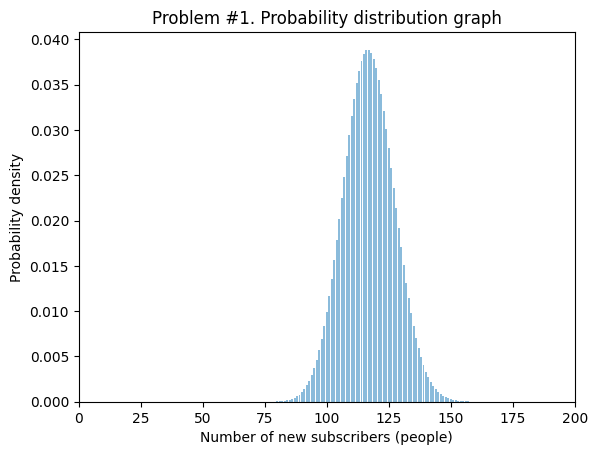

In [54]:
# 10% of users renew their subscription
p = 0.1

# selected this value by trial and error
n = 1170  # number of attempts

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)

plt.bar(range(0, n + 1), distr)

plt.title("Problem #1. Probability distribution graph")
plt.xlabel("Number of new subscribers (people)")
plt.ylabel("Probability density")

# trim the long tail of the histogram on the left
plt.xlim(0, 200);

Let's check using the `cdf()` method

In [55]:
# set the mean and standard deviation of the normal distribution equal to
# mean and standard deviation of the binomial distribution
mu = n * p
sigma = sqrt(n * p * (1 - p))

# set the normal distribution
distr = st.norm(mu, sigma)

# calculate the probability of the tail on the left
result = distr.cdf(100)
print(round(result * 100, 2), "%")

4.88 %


**Answer** \
With the number of promo codes sent out 1170, the probability of not fulfilling the plan
(getting at least 100 new subscribers) will be approximately 5%.

#### Additional task #2

The marketing department sends push notifications to customers in a mobile app. Customers can open it or not. It is known that about 40% of customers who receive notifications open them. The department plans to send out 1 million notifications.

**Our task** is to use approximation to build an approximate distribution graph and estimate the probability that no more than 399.5 thousand users will open the notification.

In [56]:
# set the parameters of the binomial distribution
n = 1000000
p = 0.4

# set the mean and standard deviation of the normal distribution equal to
# mean and standard deviation of the binomial distribution
mu = n * p
sigma = sqrt(n * p * (1 - p))

# set the normal distribution
distr = st.norm(mu, sigma)

# calculate the probability of the tail on the left
result = distr.cdf(399500)
print(round(result * 100, 2), "%")

15.37 %


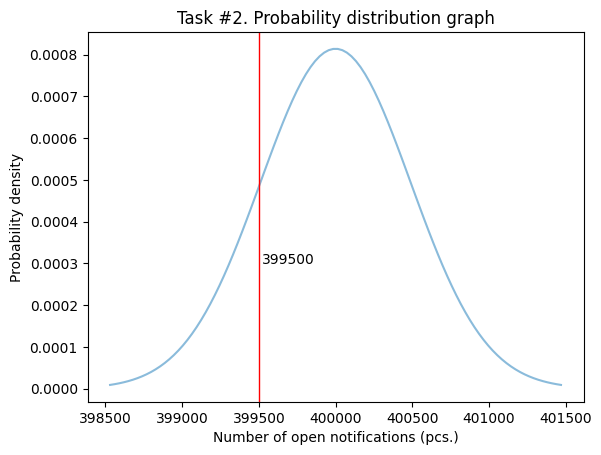

In [57]:
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
plt.plot(x, st.norm.pdf(x, mu, sigma))

plt.title("Task #2. Probability distribution graph")
plt.xlabel("Number of open notifications (pcs.)")
plt.ylabel("Probability density")

plt.axvline(399500, color="r", linestyle="-", linewidth=1)
plt.text(399520, 0.0003, "399500", rotation=0);

**Answer**\
The probability that a notification will be opened by no more than 399.5 thousand users when sending 1 million notifications is 15.37%

## Research results

**`Data preprocessing:`**

* Checked the data for gaps, as well as explicit and implicit duplicates (removed explicit ones and found the absence of hidden ones)
* In the `rides` dataset — added a new column `month`, and also corrected the `date` column type to datetime64

**`Exploratory analysis:`**

Studied and described several parameters:
* **Frequency of occurrence of cities** — the most users are from Pyatigorsk, the least — from Moscow
* **Ratio of users with and without a subscription** — users without a subscription — 54%, with a subscription — 45.6%
* **Age of users** — from 12 to 43 years old, on average, the age of users is 25 years old.
* **Distance that a user has covered in one trip** — The distribution has two distinct peaks — about 600 and 3100 meters.
* **Ride duration** — the average ride duration is 18 minutes.
* **Features of users with and without an Ultra subscription** — on average, users with an Ultra subscription make longer and longer rides. But the difference is small, only 70 m and 1 minute. The total number of rides for users with a subscription is less.

**`Hypotheses testing and following conclusions:`**

* Subscribed users probably spend more time on rides.
* It can be assumed that the average ride distance for users with an ultra subscription is 3,130 meters or more.
* Monthly revenue from users with subscriptions is higher than from users without a subscription.

**`Recommendations:`**

* The study showed that users with a subscription are more profitable for the company. Therefore, it is worth developing strategies to increase the share of subscribers among users and attract new customers.
* It is worth paying attention to attracting new users over 33 years old.
* We need to clarify the proportion of users by city and make a stratified sample.
* It is necessary to investigate the presence of a second peak in the distribution of trip distances. Perhaps this is due to the type of trip (a walk or a trip to/from work) or other factors.
* The dependence of the number of trips on the month, sorted by city, needs to be studied. If it's impossible to ride in the city in winter, we can offer a seasonal subscription only for spring, summer or autumn.
* To better understand the business processes, we need to find out why users without a subscription have trips lasting half a minute. Is this a mistake or a promotion?